In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (4179869896.py, line 17)

In [3]:
import os

import numpy as np
import pandas as pd
# Torch
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import pathlib

In [6]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Apply transformations to augment data

In [7]:
transformer = transforms.Compose([
    # Resize the image to (160, 160)
    transforms.Resize((160, 160)),     
    # Convert the image to grayscale only one channel
    transforms.Grayscale(num_output_channels=1),
    
    #Data Augmentation
    #Randomly flip the image horizontally
    transforms.RandomHorizontalFlip(),       # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),   # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),                   # Convert the image to a PyTorch tensor
])


In [36]:
#DataLoader

batchSize=128
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
train_loader = DataLoader(torchvision.datasets.ImageFolder(
                          train_path,
                          transform=transformer),
                          batch_size = batchSize,
                          shuffle=True)
val_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
val_loader = DataLoader(torchvision.datasets.ImageFolder(
                          val_path,
                          transform=transformer),
                          batch_size = batchSize)

test_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
test_loader = DataLoader(torchvision.datasets.ImageFolder(
                          test_path,
                          transform=transformer),
                          batch_size = batchSize,
                          shuffle=False)


In [52]:

total_images_train = len(train_loader.dataset)

print("Total number of images in the training dataset:", total_images_train)

total_images_test = len(test_loader.dataset)

print("Total number of images in the test dataset:", total_images_test)

Total number of images in the training dataset: 5216
Total number of images in the test dataset: 624


In [11]:
root=pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1]for j in root.iterdir()])
print(classes)

['NORMAL', 'PNEUMONIA']


In [9]:
# import matplotlib.pyplot as plt

# # Function to compute class distribution from a DataLoader
# def compute_class_distribution(data_loader):
#     class_distribution = {}
#     for _, labels in data_loader:
#         for label in labels:
#             class_distribution[label.item()] = class_distribution.get(label.item(), 0) + 1
#     return class_distribution

# # Compute class distributions
# train_class_distribution = compute_class_distribution(train_loader)
# test_class_distribution = compute_class_distribution(test_loader)
# val_class_distribution = compute_class_distribution(val_loader)

# # Plotting pie charts
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# # Train dataset
# axs[0].pie(train_class_distribution.values(), labels=train_class_distribution.keys(), autopct='%1.1f%%')
# axs[0].set_title('Train Dataset')

# # Test dataset
# axs[1].pie(test_class_distribution.values(), labels=test_class_distribution.keys(), autopct='%1.1f%%')
# axs[1].set_title('Test Dataset')

# # Validation dataset
# axs[2].pie(val_class_distribution.values(), labels=val_class_distribution.keys(), autopct='%1.1f%%')
# axs[2].set_title('Validation Dataset')

# plt.show()


In [13]:
sample_image, sample_label = train_loader.dataset[0]
print(sample_image.shape)

torch.Size([1, 160, 160])


In [48]:
class ConvNet(nn.Module):
  def __init__(self,num_classes=2):
    super(ConvNet,self).__init__()
    # input shape (256,1, 160,160)

    #output shape ((width-kernel+2P)/stride)+1 150-3+2+1=150
    self.conv1 =nn.Conv2d(in_channels=1,out_channels=20,kernel_size=3,stride=1,padding=1) # outptu channels is the number of kernels used
    #shape = 256*12*160*160
    self.bn1 = nn.BatchNorm2d(num_features=20)
    self.sigmoid1 = nn.Sigmoid()
#     self.relu1 = nn.ReLU()
   

    self.conv2 = nn.Conv2d(in_channels=20,out_channels = 32,kernel_size =3,stride=1,padding=1)
    #256*20*80*80
    self.bn2=nn.BatchNorm2d(num_features=32)
    self.pool=nn.MaxPool2d(kernel_size=2)
    #shape = 256*12*80*80 (reduce image size by 2)
    self.sigmoid2 = nn.Sigmoid()
#     self.relu2 = nn.ReLU()
    #256*20*80*80
    self.conv3 = nn.Conv2d(in_channels=32,out_channels =64,kernel_size =3,stride =1 ,padding=1)
#     #256*32*80*80
    self.bn3 = nn.BatchNorm2d(num_features=64)
    self.sigmoid3 =nn.Sigmoid()
#     self.relu3 = nn.ReLU()

    self.fc = nn.Linear(in_features=64*80*80,out_features = 2)

  def forward(self,input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.sigmoid1(output)
#     output = self.relu1(output)
    output = self.conv2(output)
    output = self.bn2(output)
    output = self.pool(output)
    output = self.sigmoid2(output)
#     output = self.relu2(output)
    output = self.conv3(output)
    output = self.bn3(output)
    output = self.sigmoid3(output)
#     output = self.relu3(output)

    output = output.view(-1,64*80*80)
    output = self.fc(output)
    return output




In [49]:
import torch.optim as optim
model = ConvNet(num_classes=2).to(device)
# optimizer =Adam(model.parameters(),lr = 0.001,weight_decay=0.0002)
optimizer = optim.Adagrad(model.parameters(), lr=0.01, weight_decay=0.0002)
num_epochs =20

Weighted Loss function:

In [20]:
weight_for_class_normal = 5291 / (1341 * 2)
weight_for_class_pneumonia = 5291 / (3875 * 2)

class_weights_tensor = torch.tensor([weight_for_class_normal, weight_for_class_pneumonia], dtype=torch.float32)
class_weights_tensor = class_weights_tensor.to(device)


# weighted loss function using to ensure that the model gives prority to the normal samples as well
#although they are much lesser in quantity
weighted_loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor)

Epoch: 0, Train Loss: 8.2937, Train Accuracy: 0.8163, Validation Accuracy: 0.5000
Epoch: 1, Train Loss: 0.9044, Train Accuracy: 0.9344, Validation Accuracy: 0.8125
Epoch: 2, Train Loss: 0.7817, Train Accuracy: 0.9390, Validation Accuracy: 0.8125
Epoch: 3, Train Loss: 0.5256, Train Accuracy: 0.9456, Validation Accuracy: 0.5625
Epoch: 4, Train Loss: 0.5261, Train Accuracy: 0.9450, Validation Accuracy: 0.5625
Epoch: 5, Train Loss: 1.5806, Train Accuracy: 0.9064, Validation Accuracy: 0.6875


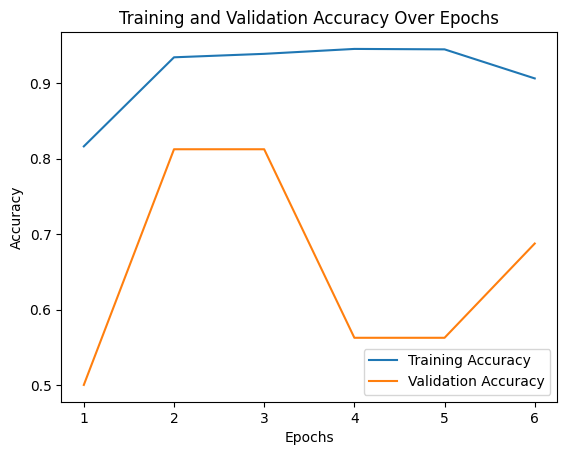

In [50]:
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(model, train_loader, optimizer, weighted_loss_function, device):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = model(images)
        loss = weighted_loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += torch.sum(prediction == labels.data).item()

    train_accuracy = train_accuracy / len(train_loader.dataset)
    train_loss = train_loss / len(train_loader.dataset)

    return train_accuracy, train_loss

def test(model, test_loader, device):
    model.eval()
    test_accuracy = 0.0
    total_images_test = len(test_loader.dataset)

    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy = test_accuracy / total_images_test

    return test_accuracy


train_accuracies = []
val_accuracies = []

best_accuracy = 0.0


for epoch in range(num_epochs):
    train_accuracy, train_loss = train(model, train_loader, optimizer, weighted_loss_function, device)
    val_accuracy = test(model, val_loader, device)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print('Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch, train_loss, train_accuracy, val_accuracy))

    # Save the best model
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), '/kaggle/working/relu_adam_128_0.001.pt')
        best_accuracy = val_accuracy



iterations = range(1, num_epochs + 1)
plt.plot(iterations, train_accuracies, label='Training Accuracy')
plt.plot(iterations, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()


In [51]:
test_accuracy = test(model, test_loader, device)
print(test_accuracy)

0.7724358974358975
